In [ ]:
! pip install transformers > /dev/null
! pip install tqdm > /dev/null

In [ ]:
import sys
#sys.path.append("/home/jovyan/palmtree/code/")
sys.path.append("/home/jovyan/work/olivetree/palmtree/code")
sys.path.append("/home/jovyan/work/olivetree/final_for_paper/Graph-Matching-Networks")

In [ ]:
# General imports
import os
import time
import json
import random
import itertools
from tqdm import tqdm

# pytorch imports
import torch
import torchmetrics
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, MetricCollection, Precision, Recall

# Transformer imports
from transformers import BertTokenizerFast
from transformers import BertForPreTraining, BertForMaskedLM

# Palmtree imports
from palmtree import dataset
from palmtree import model

`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.


In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [ ]:
# in common
base_path = "/home/jovyan/work/olivetree/final_for_paper"

base_data_path = os.path.join(base_path, "tests_cagate", "similarity", "functions", "data")
test_name = "test_functions_others_DEFINITIVE_nDCG.csv"
test_path = os.path.join(base_data_path, "definitive", test_name)
base_res_path = os.path.join(base_path, "tests_cagate", "similarity", "functions", "search_results")

# for olivetree
base_olivetree = os.path.join(base_path, "models")
base_olivetree_finetuned = os.path.join(base_path, "tests_cagate", "similarity", "functions", "fine_tuned_models", "olivetree")
tokenizer_path = os.path.join(base_path, "tokenizer")
w_tokenizer_path = os.path.join(base_path, "whitespace_tokenizer")
w2_tokenizer_path = os.path.join(base_path, "whitespace_tokenizer2")
u_tokenizer_path = os.path.join(base_path, "unigram_tokenizer")

# for palmtree
base_palmtree = os.path.join(base_path, "..", "palmtree", "models")
base_palmtree_finetuned = os.path.join(base_path, "tests_cagate", "similarity", "functions", "fine_tuned_models", "palmtree")
vocab_path = os.path.join(base_path, "..", "palmtree", "data", "palmtree_complete_dataset", "vocab")

olivetree_n_layers = 13
palmtree_n_layers = 12

ol_focus_layer = 11 # 0-based
pt_focus_layer = 10 # 0-based

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv(test_path, sep='\t')
df = df.where(pd.notnull(df), None)

queries = df[~df['ground_truth'].isnull()]
gts = [json.loads(x) for x in df["ground_truth"].to_list() if x is not None]
lens = list(map(lambda x: len(x), gts))
avg = sum(lens) / len(gts)

print(df.keys())
print(len(df))
print(len(queries))
print(avg, max(lens), min(lens))

Index(['function_id', 'ot_function', 'pt_function', 'ground_truth'], dtype='object')
58773
5000
11.7546 28 5


In [ ]:
print(df.shape)
df.head()

(58773, 4)


,function_id,ot_function,pt_function,ground_truth
0,124793,"mov rax, qword ptr [rdi] NEXT_I mov rdi, qword...",mov rax [ rdi ] NEXT_I mov rdi [ rax + 0x60 ] ...,None
1,411134,"endbr64 NEXT_I push rbp NEXT_I mov rbp, rsp N...",endbr64 NEXT_I push rbp NEXT_I mov rbp rsp NE...,None
2,409896,"endbr64 NEXT_I sub rsp, 8 NEXT_I mov rax, qwo...",endbr64 NEXT_I sub rsp 8 NEXT_I mov rax [ rsi...,None
3,205462,"sub rsp, 8 NEXT_I mov rax, qword ptr [rsi] NEX...",sub rsp 8 NEXT_I mov rax [ rsi ] NEXT_I mov rs...,None
4,214913,"mov rax, qword ptr [rsi] NEXT_I mov rsi, qword...",mov rax [ rsi ] NEXT_I mov rsi [ rax + 0x60 ] ...,"[124793, 411134, 409896, 205462, 214913, 21332..."


In [ ]:
class HParams():
    lstm_hidden_size = 128
    lstm_num_layers  = 2
    lstm_dropout     = 0
    learning_rate    = 0.0001
    dropout          = 0.2

class SiameseFinenuting(pl.LightningModule):

    def __init__(self, hparams, vocab, pt_model_path, batch_size=16, result_dir=None):

        super().__init__()

        self.batch_size = batch_size
        # self.hparams = hparams
        self.result_dir = result_dir

        self.pt_embedding = torch.load(pt_model_path)

        self.lstm  = torch.nn.LSTM(input_size   = self.pt_embedding.hidden,
                           hidden_size  = hparams.lstm_hidden_size,
                           num_layers   = hparams.lstm_num_layers,
                           dropout      = hparams.lstm_dropout,
                           batch_first  = True,
                           bidirectional= True)

        self.cosine = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

        # Criterion
        self.loss = torch.nn.MSELoss()

        # metrics
        self.train_auc = torchmetrics.AUROC()
        self.val_auc = torchmetrics.AUROC()

    def samples_embedding(self, batch):

        token_ids = batch["token_ids"]
        num_functions_ins = batch["num_functions_ins"]
        masks = batch["masks"]
        seq_lens = batch["seq_lens"]

        outputs = self.pt_embedding.encode_last(token_ids, torch.tensor(1, device="cuda"))

        # instruction embeddings
        denom = torch.sum(masks, -1, keepdim=True)
        denom[denom==0] = 1 # avoid zero denominator
        instructions_emb = torch.sum(outputs * masks.unsqueeze(-1), dim=1) / denom
        functions_outputs = torch.stack(torch.split(instructions_emb,num_functions_ins))

        # sample embedding
        # len_mask = (torch.arange(max(seq_lens),device="cuda").expand(len(seq_lens), max(seq_lens)) < seq_lens.unsqueeze(1)).type(torch.uint8)
        # denom = torch.sum(len_mask, -1, keepdim=True)
        # denom[denom==0] = 1 # avoid zero denominator
        # sample_emb = torch.sum(functions_outputs * len_mask.unsqueeze(-1), dim=1) / denom
        functions_outputs = torch.nn.utils.rnn.pack_padded_sequence(functions_outputs,
                                                          seq_lens,
                                                          batch_first=True,
                                                          enforce_sorted=False)

        outputs, _ = lstm_output = self.lstm(functions_outputs)

        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(outputs,
                                                                        batch_first=True)

        sum_unpacked = unpacked.sum(1)
        avgs = sum_unpacked/unpacked_len.unsqueeze(-1).to("cuda")

        return avgs

    def forward(self, asm_input):

        result = {}

        first_embeddings = self.samples_embedding(asm_input["first"])
        second_embeddings = self.samples_embedding(asm_input["second"])

        cosines = self.cosine(first_embeddings, second_embeddings)

        result['prediction'] = cosines
        result['labels'] = asm_input["labels"]

        return result

    def training_step(self, batch, batch_idx):
        forward_output = self.forward(batch)

        prediction = forward_output["prediction"]
        labels = forward_output["labels"]

        loss = self.loss(prediction, labels.float())

        l2 = labels.clone()
        l2[l2==-1]=0
        # self.train_auc.update(prediction, l2)
        m = self.train_auc(prediction, l2)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        self.log('train_auc', m, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)

        return {"loss":loss,
                "train_auc":m}

    def validation_step(self, batch, batch_idx):
        forward_output = self.forward(batch)

        prediction = forward_output["prediction"]
        labels = forward_output["labels"]

        loss = self.loss(prediction, labels.float())

        l2 = labels.clone()
        l2[l2==-1]=0
        # self.val_auc.update(prediction, l2)
        m = self.val_auc(prediction, l2)

        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        self.log('val_auc', m, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)

        return {"loss":loss,
                "val_auc":m}

    def test_step(self, batch, batch_idx):
        forward_output = self.forward(batch)

        prediction = forward_output["prediction"]
        labels = forward_output["labels"]

        loss = self.loss(prediction, labels.float())

        l2 = labels.clone()
        l2[l2==-1]=0
        # self.val_auc.update(prediction, l2)
        m = self.val_auc(prediction, l2)

        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        self.log('val_auc', m, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)

        # print(m)

        return {"loss":loss,
                "val_auc":m,
                "prediction": prediction,
                "labels": l2}

    def test_epoch_end(self, outputs):

        predictions = []
        references = []

        for elem in outputs:
            predictions.extend(elem["prediction"].cpu().detach().numpy())
            references.extend(elem["labels"].cpu().detach().numpy())

        compute_roc(references, predictions, self.result_dir)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LEARNING_RATE)
        return optimizer

In [ ]:
def parse_func_search_csv(df, start, end, is_olivetree=True):
    rows = []

    df_slice = df.iloc[start:end, 0:df.shape[1]]
    for index, row in df_slice.iterrows():
        if is_olivetree:
            #if row[3] is None:
            info = [" ".join(row["ot_function"].split(" NEXT_I "))]
            #else:
            #    info = [" ".join(row[1].split(" NEXT_I "))]
        else:
            #if row[3] is None:
            info = row["pt_function"].split(" NEXT_I ")[:512]
            #else:
            #    info = row[2].split(" NEXT_I ")

        if row[3] is not None:
            g_t = json.loads(row["ground_truth"])
            g_t = list(map(lambda x: int(x), g_t))
        else:
            g_t = None

        parsed_row = (int(row["function_id"]), info, g_t)
        rows.append(parsed_row)

    return rows

In [ ]:
def load_olivetree_model(tokenizer_path, best_checkpoint, mlm=False):

    print("Loading Tokenizer ->", tokenizer_path)
    tokenizer =  BertTokenizerFast.from_pretrained(tokenizer_path)

    print("Loading Model ->", best_checkpoint)
    if not mlm:
        model = BertForPreTraining.from_pretrained(best_checkpoint, output_hidden_states=True)
    else:
        model = BertForMaskedLM.from_pretrained(best_checkpoint, output_hidden_states=True)

    model.to("cuda")
    model.eval()

    return tokenizer, model

In [ ]:
def load_palmtree_model(vocab_path, best_checkpoint):

    print("Loading Vocab ->", vocab_path)
    vocab = dataset.WordVocab.load_vocab(vocab_path)

    print("Loading Model ->", best_checkpoint)
    bert = model.BERT(len(vocab), hidden=128, n_layers=12, attn_heads=8, dropout=0.0)
    bert_model = torch.load(best_checkpoint)

    bert_model.eval()
    bert_model.to("cuda")

    return vocab, bert_model

In [ ]:
def load_palmtree_lstm_model(vocab_path, best_checkpoint):

    print("Loading Vocab ->", vocab_path)
    vocab = dataset.WordVocab.load_vocab(vocab_path)

    print("Loading Model ->", best_checkpoint)
    model = SiameseFinenuting(hparams=HParams(), vocab=vocab, pt_model_path=os.path.join(base_palmtree, "complete_palmtree_model", "transformer.ep0"))
    checkpoint = torch.load(best_checkpoint)
    model.load_state_dict(checkpoint["state_dict"])

    model.eval()
    model.to("cuda")

    return vocab, model

In [ ]:
# olivetree
from time import time
from math import ceil
from tqdm.notebook import tqdm

def compute_embeddings_olivetree(tokenizer_path, model_path, df, layer, batch_size, is_cls=False):

    tokenizer, model = load_olivetree_model(tokenizer_path, model_path, mlm = False if "next" in model_path else True)
    n_iterations = ceil(df.shape[0]/batch_size)

    embeddings_list = []
    times = []

    print(f"Selected batch size {batch_size} and n iterations {n_iterations}")

    for i in tqdm(range(n_iterations)):

        time_s = time()

        start = i * batch_size
        end = (i+1) * batch_size

        functions = parse_func_search_csv(df, start, end, is_olivetree=True)

        batch_functions = []
        for f in functions:
            batch_functions.extend(f[1])



        tokenized_functions = tokenizer(batch_functions, padding=True, truncation=True, max_length=512)

        for key, value in tokenized_functions.items():
            tokenized_functions[key] = torch.tensor(value, device="cuda")

        with torch.no_grad():
            output = model(**tokenized_functions)

        #for l, layer in enumerate(layers):
            # for each layer computing the embeddings of the batch
        for i, hidden_layer in enumerate(output.hidden_states[layer]):
            if is_cls:
                function_embedding = hidden_layer[0]
            else:
                function_embedding = torch.mean(hidden_layer[tokenized_functions['attention_mask'][i].type(torch.bool)], 0)
            embeddings_list.append(function_embedding.cpu())

        #strands_matrix = torch.stack(strands_embeddings).to("cuda")
        #bbs_embeddings = torch.split(strands_matrix, batch_strands_sizes)

        #bbs_embeddings = [bb.mean(dim=0) for bb in bbs_embeddings]
        #embeddings_list.extend(strands_embeddings)

        for k in list(tokenized_functions):
            del tokenized_functions[k]
        del output
        torch.cuda.empty_cache()

        time_t = time() - time_s
        times.append(time_t)

    ids = df['function_id'].tolist()
    print(len(ids), len(embeddings_list))
    assert(len(ids) == len(embeddings_list))

    print(model_path)
    print(f"BinBert took {sum(times)/len(times)} seconds on avg to compute embeddings of a {batch_size} batch of functions")
    print(f"And in total {sum(times)} seconds for {df.shape[0]} functions")

    return ids, embeddings_list

In [ ]:
# palmtree finetuned
from math import ceil
from tqdm.notebook import tqdm

def _pad(elem, max_instr_batch, max_tok_batch, vocab):

        masks = []
        batch_token_ids = []

        num_pad_inst = max_instr_batch - len(elem)

        for j, instr in enumerate(elem):

            num_pad_tok = max_tok_batch - len(instr)
            batch_token_ids.append(instr + [vocab.pad_index] * num_pad_tok)
            masks.append([1] * len(instr) + [0] * num_pad_tok)

        batch_token_ids += [[vocab.pad_index] * max_tok_batch] * num_pad_inst
        masks += [[0] * max_tok_batch] * num_pad_inst

        return masks, batch_token_ids

def prepare_for_palmtree_lstm(strands, vocab):

    # firstly, tokenize each instruction of each strand
    # returns list (strands) of list (instructions) of list of tokens
    tok_instr_list = []
    for strand in strands:
        tok_instr = [[vocab.sos_index] + [vocab.stoi.get(tok, vocab.unk_index) for tok in instr.split()] +
                     [vocab.eos_index] for instr in strand]
        tok_instr_list.append(tok_instr)

    # finds max num ins for strand
    max_instr_batch = max([len(strand) for strand in tok_instr_list])
    # finds max num tokens for instruction for strand
    max_tok_batch = max([len(instr) for strand in tok_instr_list for instr in strand])

    masks = []
    seq_lens = []
    batch_token_ids = []

    for elem in tok_instr_list:

        seq_lens.append(len(elem))
        s_masks, s_batch_token_ids = _pad(elem, max_instr_batch, max_tok_batch, vocab)
        masks.extend(s_masks)
        batch_token_ids.extend(s_batch_token_ids)

    batch_result = {"num_functions_ins": max_instr_batch,
                    "token_ids": torch.tensor(batch_token_ids, device="cuda"),
                    "masks": torch.tensor(masks, device="cuda"),
                    "seq_lens":  seq_lens}

    return batch_result

def compute_embeddings_palmtree_lstm(vocab_path, model_path, df, batch_size):

    vocab, model = load_palmtree_lstm_model(vocab_path, model_path)
    n_iterations = ceil(df.shape[0]/batch_size)

    embeddings_list = []
    times = []

    print(f"Selected batch size {batch_size} and n iterations {n_iterations}")

    for i in tqdm(range(n_iterations)):

        time_s = time()

        start = i * batch_size
        end = (i+1) * batch_size

        functions = parse_func_search_csv(df, start, end, is_olivetree=False)

        #for each strand I have list of instructions
        batch_result = prepare_for_palmtree_lstm(list(map(lambda x: x[1], functions)), vocab)

        with torch.no_grad():
            embeddings = model.samples_embedding(batch_result)

        embeddings_list.extend(embeddings)

        torch.cuda.empty_cache()

        time_t = time() - time_s
        times.append(time_t)

    ids = df['function_id'].tolist()
    print(len(ids), len(embeddings_list))
    assert(len(ids) == len(embeddings_list))

    print(model_path)
    print(f"Palmtree took {sum(times)/len(times)} seconds on avg to compute embeddings of a {batch_size} batch of functions")
    print(f"And in total {sum(times)} seconds for {df.shape[0]} functions")

    return ids, embeddings_list

In [ ]:
# class for making fast cosine similarity
from operator import itemgetter
import torch.nn.functional as F

class SearchEngine:

    def __init__(self, checkpoint, ids_filename, layer):
        self.layer = layer
        self.ids = json.load(open(os.path.join(checkpoint, ids_filename), "r"))
        print(len(self.ids))
        self.matrix = torch.load(os.path.join(checkpoint, f"embeddings_layer_{layer}.pt"))
        self.matrix.to("cuda")

    def find_top_k(self, id_to_query, k):
        res = []
        scores = []
        idx = self.ids.index(id_to_query)

        embedding_to_query = torch.clone(self.matrix[idx])
        embedding_to_query.to("cuda")

        dist = F.cosine_similarity(self.matrix, embedding_to_query)

        index_sorted = torch.argsort(dist, descending=True)
        top_k = index_sorted[:k]

        res.extend([self.ids[k] for k in top_k])
        scores.extend([dist[k].item() for k in top_k])

        return res, scores

    def find_top_k_batch(self, ids_to_query, k):
        # list of lists
        res = []
        scores = []

        idxs = []
        for idx in ids_to_query:
            idxs.append(self.ids.index(idx))

        m_query = []
        for idx in idxs:
            m_query.append(torch.clone(self.matrix[idx]))

        m_query = torch.stack(m_query)
        m_query.to("cuda")

        a_norm = self.matrix / self.matrix.norm(dim=-1)[:, None]
        b_norm = m_query / m_query.norm(dim=-1)[:, None]

        # dist[i][j] = dist(b_norm[i] * a_norm[j])
        dist = torch.mm(b_norm, a_norm.transpose(0,1))

        for i in range(len(ids_to_query)):
            index_sorted = torch.argsort(dist[i], descending=True)
            top_k = index_sorted[:k]

            res.append([self.ids[k] for k in top_k])
            scores.append([dist[i][k].item() for k in top_k])

        return res, scores

In [ ]:
from tqdm.notebook import tqdm

def find_top_k_similar(data_path, df, batch_size, focus_layer, k):

    queries = df[~df['ground_truth'].isnull()]
    SE = SearchEngine(data_path, "functions_ids.json", focus_layer)

    p_bar = tqdm(total=len(queries))
    answers = []
    times = []

    count = 0
    gts = []
    ids = []

    for i, (index, row) in enumerate(queries.iterrows()):

        time_s = time()

        ground_truth = json.loads(row['ground_truth'])
        ground_truth = list(map(lambda x: int(x), ground_truth))
        gts.append(ground_truth)
        ids.append(row["function_id"])
        count += 1

        if len(ids) == batch_size or count == len(queries):
            top_k_lists, scores = SE.find_top_k_batch(ids, 200)

            true_labels = []
            for j in range(len(top_k_lists)):
                true_labels.append([1 if k_id in gts[j] else 0 for k_id in top_k_lists[j]])

            answers.extend([(true_labels[j], len(gts[j]), scores[j]) for j in range(len(top_k_lists))])

            time_t = time() - time_s
            times.append(time_t)

            p_bar.update(len(top_k_lists))
            gts, ids = [], []

    print(f"On inference it took {sum(times[:-1])/len(times[:-1])} seconds on avg")
    print(f"In total it took {sum(times)} seconds")

    return answers

In [ ]:
import math
import numpy as np
from tqdm.notebook import tqdm

def find_dcg(element_list):
    dcg_score = 0.0
    for j, sim in enumerate(element_list):
        dcg_score += float(sim) / math.log(j + 2)
    return dcg_score


def count_ones(element_list):
    return len([x for x in element_list if x == 1])


def extract_info(answers):

    # we analyze only one layer here
    performance1 = []
    average_recall_k1 = []
    precision_at_k1 = []

    for f_index in tqdm(range(0, len(answers))):
        # each data is a tuple of 3 elements:
        # - [0]: list of lists 1 and 0
        # - [1]: num of correct answers
        # - [2]: list of lists of similarity scores
        data = answers[f_index]

        f1 = data[0]
        pf1 = data[1]

        tp1 = []
        recall_p1 = []
        precision_p1 = []

        for k in range(1, len(f1)):
            cut1 = f1[0:k]
            dcg1 = find_dcg(cut1)
            ideal1 = find_dcg(([1] * (pf1) + [0] * (k - pf1))[0:k])

            p1k = float(count_ones(cut1))

            tp1.append(dcg1 / ideal1)
            recall_p1.append(p1k / pf1)
            precision_p1.append(p1k / k)

        performance1.append(tp1)
        average_recall_k1.append(recall_p1)
        precision_at_k1.append(precision_p1)

    avg_p1 = np.average(performance1, axis=0)
    avg_recall = np.average(average_recall_k1, axis=0)
    average_precision = np.average(precision_at_k1, axis=0)

#     std_p1 = np.std(performance1, axis=0)
#     std_recall = np.std(average_recall_k1, axis=0)
#     std_precision = np.std(precision_at_k1, axis=0)

#     return [list(avg_p1), list(std_p1)], [list(avg_recall), list(std_recall)], [list(average_precision), list(std_precision)]
    return list(avg_p1), list(avg_recall), list(average_precision)

In [ ]:
infos = []

def embeddingToNp(e):
    e = e.replace('\n', '')
    e = e.replace('[', '')
    e = e.replace(']', '')
    emb = np.fromstring(e, dtype=float, sep=' ')
    return emb

In [ ]:
# GEN-BOW

from evaluation import *
from configure import *
from dataset import *
from utils import *

config = get_default_config()
config['evaluation']['batch_size'] = 32
dataset_params = config['data']['dataset_params']
dataset_params['test_path'] = test_path.replace('.csv', '_CFG.csv')

gen_base_path = os.path.join(base_path, "Graph-Matching-Networks")

print("Loading vocab @vocab/vocab.json")
vocab = json.load(open(os.path.join(gen_base_path, "vocab/vocab.json"), "r"))

test_set = GraphFunctionSimilarityDataset(dataset_params, vocab=vocab, mode='test')
test_data_iter = test_set.list_cfg(config['evaluation']['batch_size'], stack=True)

gen_model_name = "GEN_counting_epoch20_step410892_auc_val=0.9713036599991033.pt"
model = torch.load(os.path.join(gen_base_path, "models", "counting_emb", gen_model_name))
model.eval()

times = []

with torch.no_grad():

    embeddings = []
    p_bar = tqdm(total=len(test_set._df))
    while not test_set.is_empty():

        time_s = time()

        batch = next(test_data_iter)
        node_features, edge_features, from_idx, to_idx, graph_idx, n_graphs = get_graph(batch)
        embds = model(node_features, edge_features.to("cuda"), from_idx.to("cuda"), to_idx.to("cuda"),
                           graph_idx.to("cuda"), n_graphs)

        embeddings.append(embds)

        time_t = time() - time_s
        times.append(time_t)

        p_bar.update(n_graphs)

print(f"GEN-BOW took {sum(times[:-1])/len(times[:-1])} seconds on avg to compute embeddings of a {config['evaluation']['batch_size']} batch of functions")
print(f"And in total {sum(times)} seconds for {df.shape[0]} functions")

gen_functions_ids = test_set._df['function_id'].tolist()
gen_info_path = os.path.join(base_data_path, "embeddings", "GEN-BOW")

os.makedirs(gen_info_path, exist_ok=True)
with open(os.path.join(gen_info_path, f"functions_ids.json"), "w") as f:
    json.dump(gen_functions_ids, f)

matrix = torch.vstack(embeddings)
torch.save(matrix, os.path.join(gen_info_path, f"embeddings_layer_{-1}.pt"))

gen_answers = find_top_k_similar(gen_info_path, test_set._df, 32, -1, 200)
gen_avg_p1, gen_recal_p1, gen_pre_p1 = extract_info(gen_answers)

with open(os.path.join(gen_info_path, f"{test_name}.json"), "w") as f:
    json.dump([gen_avg_p1, gen_recal_p1, gen_pre_p1], f)

# infos.append((gem_avg_p1, gem_recal_p1, gem_pre_p1))

Loading vocab @vocab/vocab.json


  0%|          | 0/58773 [00:00<?, ?it/s]

GEN-BOW took 0.0602505210957496 seconds on avg to compute embeddings of a 32 batch of functions
And in total 110.64167141914368 seconds for 58773 functions
58773


  0%|          | 0/5000 [00:00<?, ?it/s]

On inference it took 0.3398063794160501 seconds on avg
In total it took 53.108171224594116 seconds


  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
# # GEN-PT-FT

# from evaluation import *
# from configure import *
# from dataset import *
# from utils import *

# config = get_default_config()
# config['evaluation']['batch_size'] = 64
# dataset_params = config['data']['dataset_params']
# dataset_params['test_path'] = test_path.replace('.csv', '_CFG.csv')

# gen_base_path = os.path.join(base_path, "Graph-Matching-Networks")

# tokenizer_path = "/home/jovyan/work/olivetree/final_for_paper/tokenizer"
# transformer_path = "/home/jovyan/work/olivetree/final_for_paper/models/next_sentence_prediction_bert_normal_mask30/checkpoint-67246"
# gen_tokenizer, _ = load_olivetree_model_freezed(tokenizer_path, transformer_path,
#                                                               mlm=False if "next" in transformer_path else True)

# test_set = GraphFunctionSimilarityDataset(dataset_params, tokenizer=gen_tokenizer, mode='test')
# test_data_iter = test_set.list_cfg(config['evaluation']['batch_size'], capping=True, stack=False)

# gen_model_name = "GEN_pt_ft_2_epoch1_step18804_auc_val=0.9817893159835158.pt"
# model = torch.load(os.path.join(gen_base_path, "models", "pt_freezed_emb_ft_2", gen_model_name))
# model.eval()

# with torch.no_grad():

#     embeddings = []
#     p_bar = tqdm(total=len(test_set._df))
#     while not test_set.is_empty():

#         batch = next(test_data_iter)
#         node_features, edge_features, from_idx, to_idx, graph_idx, n_graphs = get_graph(batch)
#         embds = model(node_features, edge_features.to("cuda"), from_idx.to("cuda"), to_idx.to("cuda"),
#                            graph_idx.to("cuda"), n_graphs)

#         embeddings.append(embds)
#         p_bar.update(n_graphs)

# gen_functions_ids = test_set._df['function_id'].tolist()
# gen_info_path = os.path.join(base_data_path, "embeddings", "GEN-PT-FT")

# os.makedirs(gen_info_path, exist_ok=True)
# with open(os.path.join(gen_info_path, f"functions_ids.json"), "w") as f:
#     json.dump(gen_functions_ids, f)

# matrix = torch.vstack(embeddings)
# torch.save(matrix, os.path.join(gen_info_path, f"embeddings_layer_{-1}.pt"))

# gen_answers = find_top_k_similar(gen_info_path, test_set._df, 256, -1, 200)
# gen_avg_p1, gen_recal_p1, gen_pre_p1 = extract_info(gen_answers)

# with open(os.path.join(gen_info_path, f"{test_name}.json"), "w") as f:
#     json.dump([gen_avg_p1, gen_recal_p1, gen_pre_p1], f)

# # infos.append((gem_avg_p1, gem_recal_p1, gem_pre_p1))

In [ ]:
# GMN-BOW

from evaluation import *
from configure import *
from dataset import *
from utils import *

# gpu = int(os.environ["CUDA_VISIBLE_DEVICES"])

gmn_info_path = os.path.join(base_data_path, "embeddings", "GMN-BOW")

config = get_default_config()
config['evaluation']['batch_size'] = 32
dataset_params = config['data']['dataset_params']
dataset_params['test_path'] = test_path.replace('.csv', '_CFG.csv')

gmn_base_path = os.path.join(base_path, "Graph-Matching-Networks")

print("Loading vocab @vocab/vocab.json")
vocab = json.load(open(os.path.join(gmn_base_path, "vocab/vocab.json"), "r"))

test_set = GraphFunctionSimilarityDataset(dataset_params, vocab=vocab, mode='test')

gmn_model_name = "GMN_counting_epoch20_step410892_auc_val=0.9894280934953459.pt"
model = torch.load(os.path.join(gmn_base_path, "models", "counting", gmn_model_name))
model.eval()

times = []
preparations = []
inferences = []

report = open("tmp.txt", "w")

with torch.no_grad():

    functions_ids = test_set._df["function_id"].to_list()
    queries = test_set._df[~test_set._df['ground_truth'].isnull()]
    # splits = np.array_split(queries, 3)
    # queries = splits[gpu]

    gmn_answers = []
    for index, row in tqdm(queries.iterrows(), total=len(queries)):
        # print(f"Querying {row['function_id']} -> searching for {row['ground_truth']}")

        test_data_iter = test_set.list_cfg(config['evaluation']['batch_size'], query_idx=index, stack=True, capping=True)

        total_preparation = 0

        similarities = []
        while not test_set.is_empty():
            time_s = time()

            batch = next(test_data_iter)
            node_features, edge_features, from_idx, to_idx, graph_idx, n_graphs = get_graph(batch)
            eval_pairs = model(node_features, edge_features.to("cuda"), from_idx.to("cuda"), to_idx.to("cuda"),
                               graph_idx.to("cuda"), n_graphs)

            x, y = reshape_and_split_tensor(eval_pairs, 2)
            sim = compute_similarity(config, x, y)
            similarities.append(sim)

            time_t = time() - time_s
            times.append(time_t)
            total_preparation += time_t

        preparations.append(total_preparation)

        time_s = time()

        similarities = torch.cat(similarities, -1)
        index_sorted = torch.argsort(similarities, descending=True)
        top_k = index_sorted[:200]

        top_k_list, scores = [], []
        top_k_list.extend([functions_ids[k] for k in top_k])
        scores.extend([similarities[k].item() for k in top_k])

        g_t = set(json.loads(row["ground_truth"]))
        true_labels = [1 if k_id in g_t else 0 for k_id in top_k_list]
        gmn_answers.append((true_labels, len(g_t), scores))

        time_t = time() - time_s
        inferences.append(time_t)

    json.dump([times, preparations, inferences], report)
#     print(f"Avg 64 batch embeddings: {sum(times[:-1])/len(times[:-1])} seconds")

#     n_64 = int(len(inferences)/64)
#     remoduled = [sum(inferences[i:i + 64]) for i in range(0, len(inferences), 64)]

#     print(f"Avg seconds on 64 query is {sum(remoduled[:-1])/len(remoduled[:-1])} seconds")
#     print(f"Total {sum(remoduled)} seconds")

    gmn_avg_p1, gmn_recal_p1, gmn_pre_p1 = extract_info(gmn_answers)

    with open(os.path.join(gmn_info_path, f"{test_name}.json"), "w") as f:
        json.dump([gmn_avg_p1, gmn_recal_p1, gmn_pre_p1], f)

report.close()
# infos.append((gmn_avg_p1, gmn_recal_p1, gmn_pre_p1))

In [ ]:
# # FOR GMN-PT
# def pre_compute_nodes_features(df, tokenizer, trasformer):
#     nodes_features=[]
#     for index, row in tqdm(df.iterrows(), total=len(df)):
#         nodes = json.loads(row["nodes"])
#         nodes = sorted(nodes, key=lambda d: d["address"])

#         ot_ins = list(map(lambda x: " ".join(x["ot_instructions"].split(" NEXT_I ")), nodes))
#         tokenized_nodes = tokenizer(ot_ins, padding=True, truncation=True, max_length=512)

#         for key, value in tokenized_nodes.items():
#             tokenized_nodes[key] = torch.tensor(value, device="cuda")

#         output = trasformer(**tokenized_nodes)
#         hidden_states = output.hidden_states[-1]
#         masks = tokenized_nodes['attention_mask']
#         partial_mul = hidden_states * masks.unsqueeze(-1)
#         partial_sum = torch.sum(partial_mul, dim=1)
#         n = torch.sum(masks, dim=1)
#         avgs = partial_sum / n.unsqueeze(-1)

#         for k in list(tokenized_nodes):
#             del tokenized_nodes[k]
#         del output
#         torch.cuda.empty_cache()

#         nodes_features.append(avgs)

#     return nodes_features

In [ ]:
# # GMN-PT

# import copy
# from evaluation import *
# from configure import *
# from dataset import *
# from utils import *

# gmn_info_path = os.path.join(base_data_path, "embeddings", "GMN-PT")

# if os.path.exists(os.path.join(gmn_info_path, "ndcg_info.json")):
#     gmn_avg_p1 = json.load(open(os.path.join(gmn_info_path, "ndcg_info.json"), "r"))
#     gmn_recal_p1 = json.load(open(os.path.join(gmn_info_path, "recall_info.json"), "r"))
#     gmn_pre_p1 =  json.load(open(os.path.join(gmn_info_path, "precision_info.json"), "r"))
# else:
#     config = get_default_config()
#     dataset_params = config['data']['dataset_params']

#     gmn_base_path = os.path.join(base_path, "Graph-Matching-Networks")

#     tokenizer_path = "/home/jovyan/work/olivetree/final_for_paper/tokenizer"
#     transformer_path = "/home/jovyan/work/olivetree/final_for_paper/models/next_sentence_prediction_bert_normal_mask30/checkpoint-67246"
#     gmn_tokenizer, gmn_transformer = load_olivetree_model_freezed(tokenizer_path, transformer_path,
#                                                                   mlm=False if "next" in transformer_path else True)

#     test_set = GraphFunctionSimilarityDataset(dataset_params, mode='test')

#     gmn_model_name = "GMN_pt_epoch3_step410892_auc_val=0.9959328000944714.pt"
#     model = torch.load(os.path.join(gmn_base_path, "models", "pt_freezed", gmn_model_name))

#     true_model, optimizer = build_model(config, 768, 16, pt_model=gmn_transformer)
#     true_model.load_state_dict(model.state_dict())
#     true_model.to("cuda")
#     true_model.eval()

#     with torch.no_grad():

#         functions_ids = test_set._df["function_id"].to_list()
#         queries = test_set._df[~test_set._df['ground_truth'].isnull()]

#         # memoization of tokenized nodes for each functions
#         print("Tokenization and pre-computation of nodes embeddings...")
#         embeddings = pre_compute_nodes_features(test_set._df, gmn_tokenizer, true_model._pt_model)
#         print(len(embeddings))

#         gmn_answers = []
#         for index, row in tqdm(queries.iterrows(), total=len(queries)):
#             test_data_iter = test_set.list_cfg(config['evaluation']['batch_size'], query_idx=index, stack=False)

#             counter = 0
#             similarities = []
#             while not test_set.is_empty():

#                 batch = next(test_data_iter)
#                 node_features, edge_features, from_idx, to_idx, graph_idx, n_graphs = get_graph(batch)

#                 node_features = []
#                 for i in range(counter, counter+int(n_graphs/2)):
#                     if i < len(embeddings):
#                         node_features.extend([torch.clone(embeddings[i]), torch.clone(embeddings[index])])

#                 eval_pairs = true_model(node_features, edge_features.to("cuda"), from_idx.to("cuda"), to_idx.to("cuda"),
#                                    graph_idx.to("cuda"), n_graphs, is_test=True)

#                 x, y = reshape_and_split_tensor(eval_pairs, 2)
#                 sim = compute_similarity(config, x, y)
#                 similarities.append(sim)
#                 counter += int(n_graphs/2)

#             similarities = torch.cat(similarities, -1)
#             index_sorted = torch.argsort(similarities, descending=True)
#             top_k = index_sorted[:200]

#             top_k_list, scores = [], []
#             top_k_list.extend([functions_ids[k] for k in top_k])
#             scores.extend([similarities[k].item() for k in top_k])

#             g_t = set(json.loads(row["ground_truth"]))
#             true_labels = [1 if k_id in g_t else 0 for k_id in top_k_list]
#             gmn_answers.append((true_labels, len(g_t), scores))

#         gmn_avg_p1, gmn_recal_p1, gmn_pre_p1 = extract_info(gmn_answers)
#         os.makedirs(gmn_info_path, exist_ok=True)
#         json.dump(list(gmn_avg_p1), open(os.path.join(gmn_info_path, "ndcg_info.json"), "w"))
#         json.dump(list(gmn_recal_p1), open(os.path.join(gmn_info_path, "recall_info.json"), "w"))
#         json.dump(list(gmn_pre_p1), open(os.path.join(gmn_info_path, "precision_info.json"), "w"))

# infos.append((gmn_avg_p1, gmn_recal_p1, gmn_pre_p1))

In [ ]:
# # GMN-PT-FT

# import copy
# from evaluation import *
# from configure import *
# from dataset import *
# from utils import *

# gmn_info_path = os.path.join(base_data_path, "embeddings", "GMN-PT-FT")

# gpu = int(os.environ["CUDA_VISIBLE_DEVICES"])

# config = get_default_config()
# config['evaluation']['batch_size'] = 128
# dataset_params = config['data']['dataset_params']
# dataset_params['test_path'] = test_path.replace('.csv', '_CFG.csv')

# gmn_base_path = os.path.join(base_path, "Graph-Matching-Networks")

# tokenizer_path = "/home/jovyan/work/olivetree/final_for_paper/tokenizer"
# transformer_path = "/home/jovyan/work/olivetree/final_for_paper/models/next_sentence_prediction_bert_normal_mask30/checkpoint-67246"
# gmn_tokenizer, _ = load_olivetree_model_freezed(tokenizer_path, transformer_path,
#                                                 mlm=False if "next" in transformer_path else True)

# test_set = GraphFunctionSimilarityDataset(dataset_params, mode='test')

# gmn_model_name = "GMN_pt_ft_epoch15_step18804_auc_val=0.9969054484122147.pt"
# model = torch.load(os.path.join(gmn_base_path, "models", "pt_freezed_ft_2", gmn_model_name))
# model.to("cuda")
# model.eval()

# with torch.no_grad():

#     functions_ids = test_set._df["function_id"].to_list()
#     queries = test_set._df[~test_set._df['ground_truth'].isnull()]
#     splits = np.array_split(queries, 4)
#     queries = splits[gpu]

#     # memoization of tokenized nodes for each functions
#     print("Tokenization and pre-computation of nodes embeddings...")
#     embeddings = pre_compute_nodes_features(test_set._df, gmn_tokenizer, model._pt_model)
#     print(len(embeddings))

#     gmn_answers = []
#     for index, row in tqdm(queries.iterrows(), total=len(queries)):
#         if os.path.exists(os.path.join(gmn_info_path, f"index_{str(index).zfill(4)}_gpu_{gpu}.json")):
#             continue
#         test_data_iter = test_set.list_cfg(config['evaluation']['batch_size'], query_idx=index, stack=False, capping=True)

#         counter = 0
#         similarities = []
#         while not test_set.is_empty():

#             batch = next(test_data_iter)
#             node_features, edge_features, from_idx, to_idx, graph_idx, n_graphs = get_graph(batch)

#             node_features = []
#             for i in range(counter, counter+int(n_graphs/2)):
#                 if i < len(embeddings):
#                     node_features.extend([torch.clone(embeddings[i]).to("cuda"), torch.clone(embeddings[index]).to("cuda")])

#             eval_pairs = model(node_features, edge_features.to("cuda"), from_idx.to("cuda"), to_idx.to("cuda"),
#                                graph_idx.to("cuda"), n_graphs, is_test=True)

#             x, y = reshape_and_split_tensor(eval_pairs, 2)
#             sim = compute_similarity(config, x, y)
#             similarities.append(sim)
#             counter += int(n_graphs/2)

#         similarities = torch.cat(similarities, -1)
#         index_sorted = torch.argsort(similarities, descending=True)
#         top_k = index_sorted[:200]

#         top_k_list, scores = [], []
#         top_k_list.extend([functions_ids[k] for k in top_k])
#         scores.extend([similarities[k].item() for k in top_k])

#         g_t = set(json.loads(row["ground_truth"]))
#         true_labels = [1 if k_id in g_t else 0 for k_id in top_k_list]
#         gmn_answers.append((true_labels, len(g_t), scores))

#         with open(os.path.join(gmn_info_path, f"index_{str(index).zfill(4)}_gpu_{gpu}.json"), "w") as f:
#             json.dump([true_labels, len(g_t), scores], f)

#     gmn_avg_p1, gmn_recal_p1, gmn_pre_p1 = extract_info(gmn_answers)

#     with open(os.path.join(gmn_info_path, f"{test_name}_{gpu}.json"), "w") as f:
#         json.dump([gmn_avg_p1, gmn_recal_p1, gmn_pre_p1], f)

# # infos.append((gmn_avg_p1, gmn_recal_p1, gmn_pre_p1))

In [ ]:
# TREX

TREX_info = test_path.replace(".csv", "_TREX.csv")
TREX_path = os.path.join(base_data_path, "embeddings", "TREX")

df_trex = pd.read_csv(TREX_info, sep='\t')
df_trex = df_trex.where(pd.notnull(df_trex), None)

trex_functions_ids = df_trex['function_id'].tolist()

os.makedirs(TREX_path, exist_ok=True)
with open(os.path.join(TREX_path, f"functions_ids.json"), "w") as f:
    json.dump(trex_functions_ids, f)

trex_embeddings = df_trex['embedding'].to_list()

trex_embeddings = list(map(lambda x: torch.from_numpy(np.array(json.loads(x))), trex_embeddings))
matrix = torch.stack(trex_embeddings)
torch.save(matrix, os.path.join(TREX_path, f"embeddings_layer_{-1}.pt"))

trex_answers = find_top_k_similar(TREX_path, df_trex, 32, -1, 200)
trex_avg_p1, trex_recal_p1, trex_pre_p1 = extract_info(trex_answers)

with open(os.path.join(TREX_path, f"{test_name}.json"), "w") as f:
    json.dump([trex_avg_p1, trex_recal_p1, trex_pre_p1], f)

# infos.append((trex_avg_p1, trex_recal_p1, trex_pre_p1))

In [ ]:
# SAFE

SAFE_info = test_path.replace(".csv", "_SAFE.csv")
SAFE_path = os.path.join(base_data_path, "embeddings", "SAFE")

df_safe = pd.read_csv(SAFE_info, sep='\t')
df_safe = df_safe.where(pd.notnull(df_safe), None)
# print(df_safe.keys())
df_safe.rename(columns = {'ot_function_id':'function_id'}, inplace = True)
# print(df_safe.keys())

safe_functions_ids = df_safe['function_id'].tolist()

os.makedirs(SAFE_path, exist_ok=True)
with open(os.path.join(SAFE_path, f"functions_ids.json"), "w") as f:
    json.dump(safe_functions_ids, f)

safe_embeddings = df_safe['embedding'].to_list()
safe_embeddings = list(map(lambda x: torch.from_numpy(embeddingToNp(x)), safe_embeddings))
matrix = torch.stack(safe_embeddings)
torch.save(matrix, os.path.join(SAFE_path, f"embeddings_layer_{-1}.pt"))

safe_answers = find_top_k_similar(SAFE_path, df_safe, 32, -1, 200)
safe_avg_p1, safe_recal_p1, safe_pre_p1 = extract_info(safe_answers)

with open(os.path.join(SAFE_path, f"{test_name}.json"), "w") as f:
    json.dump([safe_avg_p1, safe_recal_p1, safe_pre_p1], f)

# infos.append((safe_avg_p1, safe_recal_p1, safe_pre_p1))

58773


  0%|          | 0/5000 [00:00<?, ?it/s]

On inference it took 1.0469988538668706 seconds on avg
In total it took 163.6401469707489 seconds


  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
# # Asm2Vec
# import json, sys
# from scipy import spatial

# df_ext = pd.read_csv(os.path.join(base_data_path, "test_functions_nDCG_extended.csv"), sep='\t')
# df_ext = df_ext.where(pd.notnull(df_ext), None)
# print(df_ext.keys())

# missing = 0

# paths = []
# asm2vec_functions_ids = []
# g_t = []

# asm2vec_embeddings = []

# base_asm2vec_path = os.path.join(base_path, "asm2vec", "asm2vec-pytorch")
# sys.path.append(base_asm2vec_path)
# import asm2vec

# for row in tqdm(df_ext.values):
#     bin_info = row[-1]
#     tokens = bin_info.split('/')
#     base_func_path_a2v = os.path.join(base_asm2vec_path, "disasm_testing", tokens[0], tokens[1], tokens[2], tokens[3])

#     if not os.path.exists(base_func_path_a2v):
#         print(f"{base_func_path_a2v} does not exist")
#         continue

#     func_path_a2v = os.path.join(base_func_path_a2v, tokens[4])
#     if not os.path.exists(func_path_a2v):
#         func_path_a2v = os.path.join(base_func_path_a2v, f"sym.{tokens[4]}")

#         if not os.path.exists(func_path_a2v):
#             func_path_a2v = os.path.join(base_func_path_a2v, f"dbg.{tokens[4]}")

#             if not os.path.exists(func_path_a2v):
#                 print(f"{base_func_path_a2v} -> {tokens[4]} does not exist")
#                 missing += 1
#                 continue

#     paths.append(func_path_a2v)
#     asm2vec_functions_ids.append(row[0])
#     g_t.append(row[3])

#     assert(len(paths) == len(asm2vec_functions_ids) == len(g_t))

# if missing > 0:
#     print(f"{missing} missing files")


# # computing the embeddings
# asm2vec_model_path = os.path.join(base_asm2vec_path, "model", "asm2vec_model.pt")
# asm2vec_model, a2v_tokens = asm2vec.utils.load_model(asm2vec_model_path, device='cuda')

# a2v_functions, a2v_tokens_new = asm2vec.utils.load_data(paths)
# a2v_tokens.update(a2v_tokens_new)
# asm2vec_model.update(len(a2v_functions), a2v_tokens.size())
# asm2vec_model = asm2vec_model.to('cuda')

# # train function embedding
# asm2vec_model = asm2vec.utils.train(
#     a2v_functions,
#     a2v_tokens,
#     model=asm2vec_model,
#     epochs=10,
#     device='cuda',
#     mode='test',
#     learning_rate=0.02
# )

# asm2vec_data_path = os.path.join(base_data_path, "embeddings", "ASM2VEC")

# embeddings = asm2vec_model.to('cpu').embeddings_f(torch.tensor(range(len(a2v_functions))))
# embeddings = list(map(lambda x: x.detach().cpu(), embeddings))
# matrix = torch.stack(embeddings)
# torch.save(matrix, os.path.join(asm2vec_data_path, f"embeddings_layer_{-1}.pt"))

# with open(os.path.join(asm2vec_data_path, f"functions_ids.json"), "w") as f:
#     json.dump(asm2vec_functions_ids, f)

# rows = list(zip(asm2vec_functions_ids, g_t))
# pd_kv = pd.DataFrame(rows, columns=["function_id", "ground_truth"])

# asm2vec_answers = find_top_k_similar(asm2vec_data_path, pd_kv, 1, -1, 200)
# asm2_avg_p1, asm2_recal_p1, asm2_pre_p1 = extract_info(asm2vec_answers)
# infos.append((asm2_avg_p1, asm2_recal_p1, asm2_pre_p1))

In [ ]:
# olivetree
ot_lst = [
    #("nsp_normal_mask30_avg", "epoch-1", True, False),
    #("nsp_normal_mask30_avg_cos_emb_loss", "epoch-2", True, False),
    #("mlm_normal_mask30_avg", "epoch-1", True, False),
    #("from_scratch_normal_avg", "epoch-6", True, False),
    #("nsp_normal_mask30_triplet_loss", "epoch-16", True, False),
    #("mlm_normal_mask30_triplet_loss", "epoch-12", True, False),
    ("nsp_normal_unigram_mask30_triplet_loss", "epoch-10", True, False),
    ("nsp_normal_whitespace_mask30_triplet_loss", "epoch-9", True, False),
    ("nsp_normal_whitespace2_mask30_triplet_loss", "epoch-15", True, False),
    ("from_scratch_normal_triplet_loss", "epoch-18", True, False)
]

for olivetree_model_name, olivetree_checkpoint, is_fine_tuned, is_cls in ot_lst:
    if is_fine_tuned:
        olivetree_model_path = os.path.join(base_olivetree_finetuned, olivetree_model_name, olivetree_checkpoint)
    else:
        olivetree_model_path = os.path.join(base_olivetree, olivetree_model_name, olivetree_checkpoint)

    focus_layer = ol_focus_layer if not is_fine_tuned else -1

    # time_start = time.time()
    if "unigram" in olivetree_model_name:
        t_path = u_tokenizer_path
    elif "whitespace2" in olivetree_model_name:
        t_path = w2_tokenizer_path
    elif "whitespace" in olivetree_model_name:
        t_path = w_tokenizer_path
    else:
        t_path = tokenizer_path

    ot_functions_ids, ot_embeddings_list = compute_embeddings_olivetree(t_path, olivetree_model_path, df, focus_layer, 32, is_cls=is_cls)

    ot_path = os.path.join(base_data_path, "embeddings", olivetree_model_name, olivetree_checkpoint)
    os.makedirs(ot_path, exist_ok=True)
    with open(os.path.join(ot_path, f"functions_ids.json"), "w") as f:
        json.dump(ot_functions_ids, f)

    #for layer_id in range(len(ot_embeddings_list)):
    embeddings = ot_embeddings_list
    matrix = torch.stack(embeddings)
    torch.save(matrix, os.path.join(ot_path, f"embeddings_layer_{focus_layer}.pt"))

    olivetree_answers = find_top_k_similar(ot_path, df, 32, focus_layer, 200)
    ol_avg_p1, ol_recal_p1, ol_pre_p1 = extract_info(olivetree_answers)

    # infos.append((ol_avg_p1, ol_recal_p1, ol_pre_p1))
    # time_end = time.time() - time_start

    # print(f"BinBert takes {time_end} to complete test")

    with open(os.path.join(ot_path, f"{test_name}.json"), "w") as f:
        json.dump([ol_avg_p1, ol_recal_p1, ol_pre_p1], f)

In [ ]:
# palmtree lstm finetuned
pt_lst = [
    ("epoch1_finetuning_lstm", "epoch=15-val_auc=0.9779.ckpt", True),
    ("from_scratch_finetuning_lstm", "epoch=18-val_auc=0.9613.ckpt", True)
]

for palmtree_model_name, palmtree_checkpoint, is_fine_tuned in pt_lst:
    palmtree_model_path = os.path.join(base_palmtree_finetuned, palmtree_model_name, palmtree_checkpoint)

    focus_layer = pt_focus_layer if not is_fine_tuned else pt_focus_layer + 1

    pt_functions_ids, pt_embeddings_list = compute_embeddings_palmtree_lstm(vocab_path, palmtree_model_path, df, 32)
    pt_path = os.path.join(base_data_path, "embeddings", palmtree_model_name, palmtree_checkpoint)
    os.makedirs(pt_path, exist_ok=True)

    with open(os.path.join(pt_path, f"functions_ids.json"), "w") as f:
        json.dump(pt_functions_ids, f)

    #for layer_id in range(len(pt_embeddings_list)):

    embeddings = pt_embeddings_list
    matrix = torch.stack(embeddings)
    torch.save(matrix, os.path.join(pt_path, f"embeddings_layer_{focus_layer}.pt"))

    palmtree_answers = find_top_k_similar(pt_path, df, 32, focus_layer, 200)
    pt_avg_p1, pt_recal_p1, pt_pre_p1 = extract_info(palmtree_answers)

    # infos.append((pt_avg_p1, pt_recal_p1, pt_pre_p1))

    with open(os.path.join(pt_path, f"{test_name}.json"), "w") as f:
        json.dump([pt_avg_p1, pt_recal_p1, pt_pre_p1], f)

### Plotting results

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def print_graph(scores, stds, max_pos, file_name, label_y, titles, image_title=None):

    plt.clf()
    plt.grid()

    plt.xlabel("Number of Nearest Results")
    plt.ylabel(label_y)
    plt.ylim([0, 1])

#     cmap = plt.get_cmap('brg')
#     colors = [cmap(i) for i in np.linspace(0.2, 0.9, len(titles))]

    for i, title in enumerate(titles):

        x = range(0, max_pos)
        y = scores[i][:max_pos]

#         X_Y_Spline = make_interp_spline(x, y)
#         X_ = np.linspace(0, max_pos, 500)
#         Y_ = X_Y_Spline(X_)
        y_std_plus = y + stds[i][:max_pos]
        y_std_minus = y - stds[i][:max_pos]

#         title == "GEM-BOW"
#         title == "GMN-PT-FT"
#         or title == "GMN-PT"
#         or title == "GMN-BOW"
#         title == "Asm2Vec"
        if title == "BinBert-FT":
            color = "tab:blue"
        elif title == "BinBert-MLM-FT":
            color = "tab:orange"
        elif title == "BinBert-FS":
            color = "tab:green"
        elif title == "PalmTree-FT":
            color = "tab:red"
        elif title == "SAFE":
            color = "tab:olive"
        elif title == "GEN-BOW":
            color = "tab:purple"
        elif title == "GMN-BOW":
            color = "tab:cyan"
        elif title == "TREX-FT":
            color = "tab:brown"

        plt.plot(x, y, label=title, color=color, linewidth=0.7, linestyle="solid")
        plt.fill_between(x, y, y_std_plus, alpha=.4, color=color, linewidth=0)
        plt.fill_between(x, y, y_std_minus, alpha=.4, color=color, linewidth=0)
#         plt.plot(x, y_std_plus, color=color, linewidth=1, linestyle="dashed")
#         plt.plot(x, y_std_minus, color=color, linewidth=1, linestyle="dashed")

    if image_title is not None:
        plt.title(image_title)

    plt.legend(prop={'size': 8})
    #plt.legend()
    plt.savefig(file_name, dpi=500, format="pdf")
    plt.close(file_name)

In [ ]:
from texttable import Texttable

def print_table(info, titles):
    t = Texttable(max_width=1000)
    # idx = [4, 9, 14, 19, 24, 29, 34, 39, 44, 49]
    idx = [4, 9, 24]
    hit_labels = ['model'] + [f'hit-{i+1}' for i in idx]
    t.add_row(hit_labels)

    for i, model in enumerate(titles):
        local_info = [info[i][j] for j in idx]
        local_info.insert(0, model)
        t.add_row(local_info)

    print(t.draw())

Results nDCG
+----------------+-------+--------+--------+
| model          | hit-5 | hit-10 | hit-25 |
+----------------+-------+--------+--------+
| BinBert-FT     | 0.834 | 0.747  | 0.740  |
+----------------+-------+--------+--------+
| BinBert-MLM-FT | 0.813 | 0.718  | 0.708  |
+----------------+-------+--------+--------+
| BinBert-FS     | 0.514 | 0.399  | 0.380  |
+----------------+-------+--------+--------+
| PalmTree-FT    | 0.694 | 0.567  | 0.542  |
+----------------+-------+--------+--------+
| GEN-BOW        | 0.614 | 0.495  | 0.475  |
+----------------+-------+--------+--------+
| TREX-FT        | 0.781 | 0.678  | 0.665  |
+----------------+-------+--------+--------+
| SAFE           | 0.638 | 0.511  | 0.494  |
+----------------+-------+--------+--------+

Results Precision
+----------------+-------+--------+--------+
| model          | hit-5 | hit-10 | hit-25 |
+----------------+-------+--------+--------+
| BinBert-FT     | 0.785 | 0.592  | 0.315  |
+----------------+-----

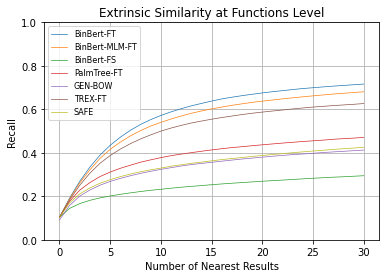

In [ ]:
model_lists = [
    ("nsp_normal_mask30_triplet_loss", "epoch-16", "BinBert-FT"),
    ("mlm_normal_mask30_triplet_loss", "epoch-12", "BinBert-MLM-FT"),
    #("nsp_normal_unigram_mask30_triplet_loss", "epoch-10", "BinBert-FT-Unigram"),
    #("nsp_normal_whitespace_mask30_triplet_loss", "epoch-9", "BinBert-FT-Whitespace"),
    #("nsp_normal_whitespace2_mask30_triplet_loss", "epoch-15", "BinBert-FT-Whitespace2"),
    ("from_scratch_normal_triplet_loss", "epoch-18", "BinBert-FS"),
    ("epoch1_finetuning_lstm", "epoch=15-val_auc=0.9779.ckpt", "PalmTree-FT"),

    # ("from_scratch_finetuning_lstm", "epoch=18-val_auc=0.9613.ckpt", ""),
    ("GEN-BOW", "", "GEN-BOW"),
    # ("GMN-BOW", "", "GMN-BOW"),
    ("TREX", "", "TREX-FT"),
    ("SAFE", "", "SAFE"),
]

titles = list(map(lambda x: x[2], model_lists))

res_names = [
    "test_functions_others_DEFINITIVE_nDCG.csv.json",
]

n, r, p = [], [], []
sn, sr, sp = [], [], []

for model_name, checkpoint, _ in model_lists:

    json_base_path = os.path.join(base_data_path, "embeddings", model_name, checkpoint)

    n_local, r_local, p_local = [], [], []
    for res_name in res_names:
        res_json = json.load(open(os.path.join(json_base_path, res_name)))
        n_local.append(res_json[0])
        r_local.append(res_json[1])
        p_local.append(res_json[2])

    n.append(np.mean(n_local, axis=0))
    r.append(np.mean(r_local, axis=0))
    p.append(np.mean(p_local, axis=0))

    sn.append(np.std(n_local, axis=0))
    sr.append(np.std(r_local, axis=0))
    sp.append(np.std(p_local, axis=0))

print_graph(n, sn, 31, os.path.join(base_res_path, "nDCG_functions_extrinsic.pdf"), "nDCG",
            titles, image_title="Extrinsic Similarity at Functions Level")
print_graph(p, sp, 31, os.path.join(base_res_path, f"precision_functions_extrinsic.pdf"), "Precision",
            titles, image_title="Extrinsic Similarity at Functions Level")
print_graph(r, sr, 31, os.path.join(base_res_path, f"recall_functions_extrinsic.pdf"), "Recall",
            titles, image_title="Extrinsic Similarity at Functions Level")

print("Results nDCG")
print_table(n, titles)
print()
print("Results Precision")
print_table(p, titles)
print()
print("Results Recall")
print_table(r, titles)